In [19]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from scipy.stats import zscore

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense, Activation

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [20]:
train_data = h5py.File('Signs_Data_Training.h5')
test_data = h5py.File('Signs_Data_Testing.h5')

In [21]:
train_data.keys() , test_data.keys()


(<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>,
 <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>)

In [22]:
X_train = train_data['train_set_x']
y_train = train_data['train_set_y']
X_test = test_data['test_set_x']
y_test = test_data['test_set_y']

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1080, 64, 64, 3), (1080,), (120, 64, 64, 3), (120,))

## Quality check

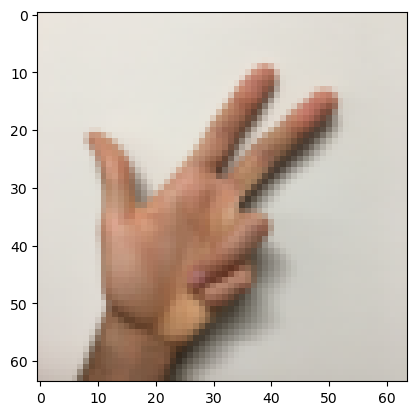

3


In [24]:
index = 540
plt.imshow(X_train[index])
plt.show();
print(y_train[index])

In [25]:
# convert them all to arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [26]:
X_train = X_train.reshape(1080,-1)
X_train = pd.DataFrame(X_train)
X_test = X_test.reshape(120,-1)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [27]:
# check if the pixels are in the range of 0 and 255
for i in range (X_train.shape[1]):
    for j in range (X_train.shape[0]):
       if X_train[i][j] > 255: 
           print(f'Error at i= {i} and error at j = {j} value = {X_train[i,j]}')
 


In [28]:
# change the y_train and y_test to label
y_train.columns = ['Label']
y_test.columns = ['Label']

In [29]:
# Check if the training label have balanced data
y_train['Label'].value_counts()

Label
5    180
0    180
2    180
4    180
1    180
3    180
Name: count, dtype: int64

In [30]:
# check if the test label have balanced data
y_test['Label'].value_counts()

Label
0    20
5    20
1    20
3    20
4    20
2    20
Name: count, dtype: int64

In [31]:
# Normalize the data
X_train_norm = zscore(X_train) 
X_train_norm = X_train_norm.reshape(1080, 64, 64, 3)

In [32]:
X_test_norm = zscore(X_test)
X_test_norm = X_test_norm.reshape(120,64,64,3)

In [33]:
# one hot encode train labels
y_train_norm = pd.get_dummies(y_train['Label'])
y_train_norm.shape

(1080, 6)

In [34]:
# one hot encode test label
y_test_norm = pd.get_dummies(y_test['Label'])
y_test_norm.shape

(120, 6)

In [35]:
# create model
def create_model(input_shape, learning_rate = 0.001):
 X_input = Input(input_shape)

# layer 1
 X = Conv2D(16, (3, 3), padding= 'same', activation='relu', name='Conv1')(X_input)
 X = MaxPool2D((2, 2), name='Pool1')(X)
 X = Dropout(0.2)(X)
 #layer 2

 X = Conv2D(32, (3,3), padding = 'same', activation = 'relu', name = 'Conv2')(X)
 X = MaxPool2D((2,2), name = 'Pool2')(X)
 X = Dropout(0.2)(X)

 # Fully connected layers
 X = Flatten()(X)
 X = Dense(64, activation = 'relu', name = 'fc1')(X)
 X = Dropout(0.2)(X)

# output layer
 X = Dense(6, activation = 'softmax', name = 'output')(X)

 model= Model(inputs = X_input, outputs= X)
 model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
 return model

In [36]:
# instantiate model
M1 = create_model(X_train_norm.shape[1:])

In [37]:
# train
M1.fit(X_train_norm, y_train_norm, epochs = 150,batch_size =16,verbose = 1)

Epoch 1/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.3925 - loss: 1.7380
Epoch 2/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7517 - loss: 0.6371
Epoch 3/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8493 - loss: 0.3759
Epoch 4/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9198 - loss: 0.2306
Epoch 5/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9340 - loss: 0.1885
Epoch 6/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9470 - loss: 0.1392
Epoch 7/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9686 - loss: 0.1095
Epoch 8/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9726 - loss: 0.0876
Epoch 9/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9574 - loss: 0.1119
Epoch 10/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9771 - loss: 0.0652
Epoch 11/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9814 - loss: 0.0538
Epoch 12/150
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

In [38]:
# check the summary
M1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,589,492 (6.06 MB)

 Trainable params: 529,830 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,059,662 (4.04 MB)

In [39]:
# training accuracy
y_train_pred = M1.predict(X_train_norm)
y_train_pred = np.argmax(y_train_pred, axis = 1)
print(accuracy_score(y_train, y_train_pred))



34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1.0


In [40]:
# testing accuracy
y_test_pred = M1.predict(X_test_norm)
y_test_pred = np.argmax(y_test_pred, axis = 1)
print(accuracy_score(y_test, y_test_pred))



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.9916666666666667


In [41]:
preds = M1.evaluate(X_test_norm, y_test_norm, batch_size=32, verbose=1, sample_weight=None)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9915 - loss: 0.0319     


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


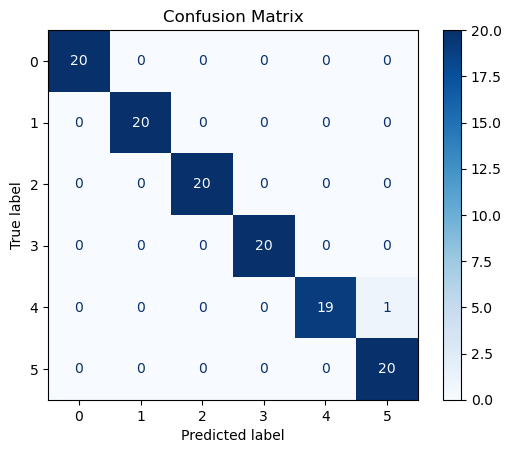

In [42]:
# plot a confusion matrix

# Get true and predicted values
y_pred = np.argmax(M1.predict(X_test_norm), axis=1)
y_true = np.argmax(y_test_norm, axis=1) 

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.951846298275639..1.164816036784385].


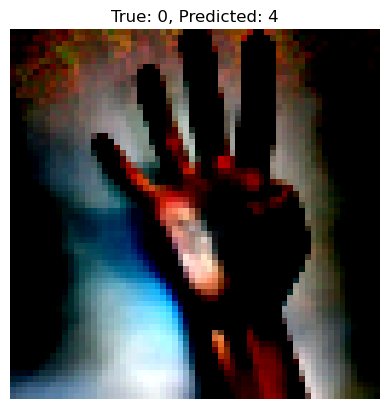

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.351057864286046..1.6460775794559461].


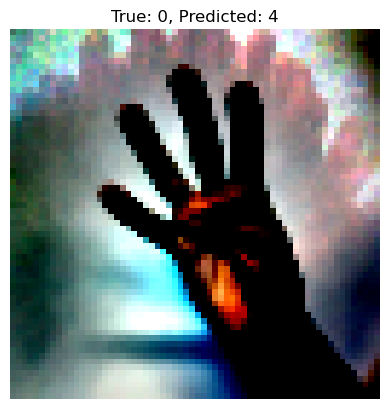

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5622562189069344..2.4302111628801226].


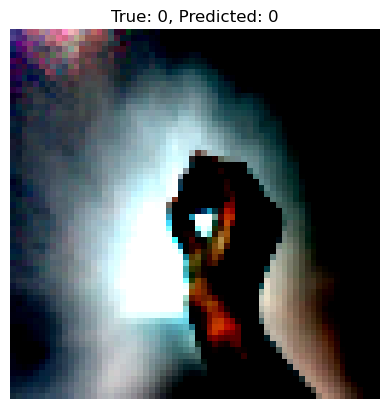

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.762959811575205..1.7847005967263894].


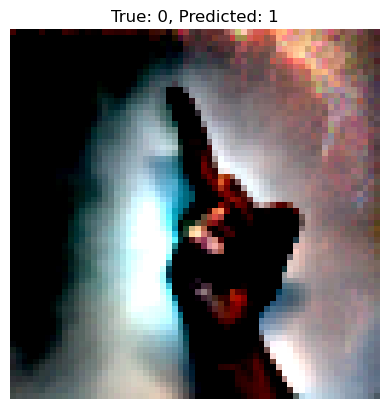

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.0170200562146405..2.669932195953937].


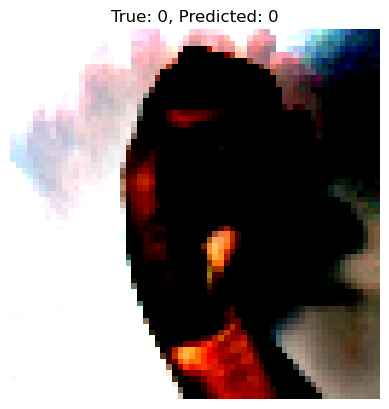

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.739663774848721..1.8866438500294587].


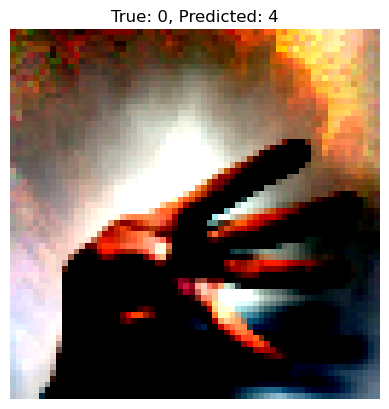

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.762959811575205..1.7847005967263894].


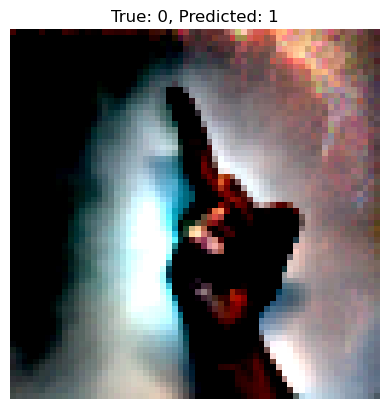

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6928616456316967..2.0935736050112768].


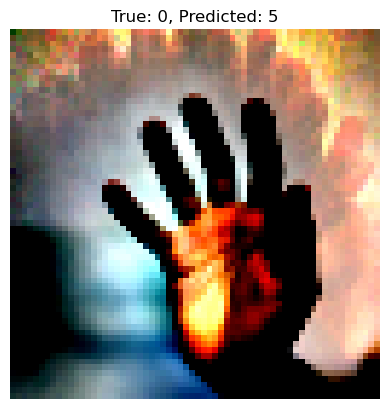

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.837978719595142..1.8176698126864834].


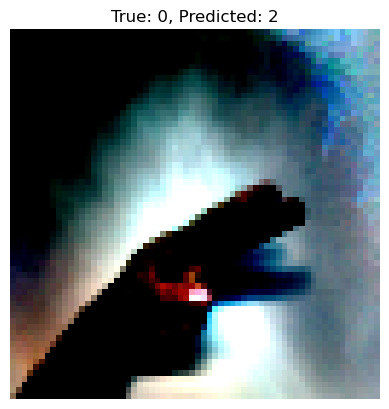

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2443475395247616..1.5744134966099803].


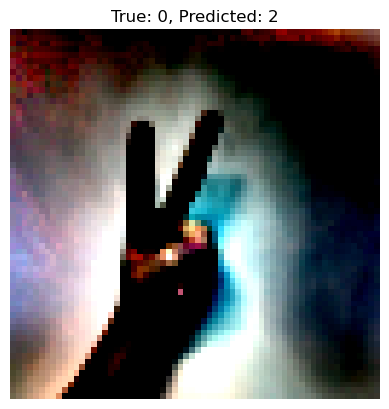

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.951846298275639..1.164816036784385].


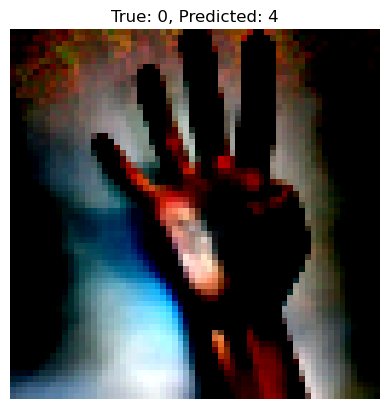

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.254393973505567..1.8982537588086499].


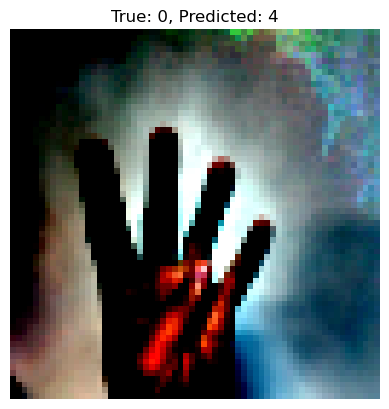

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8602490348747396..2.166522435283296].


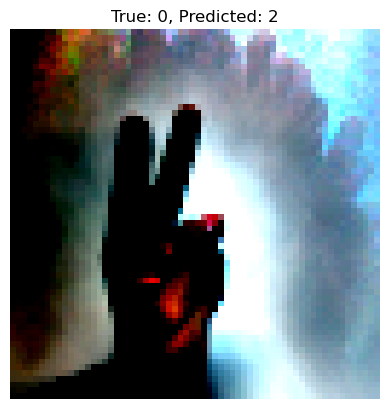

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9460551782522666..1.8655358926806482].


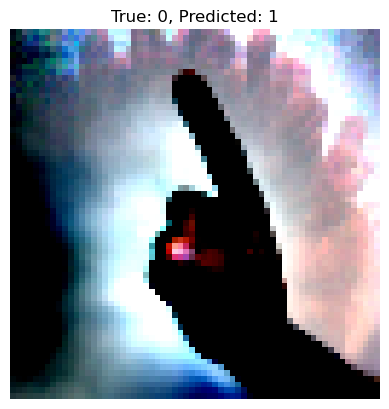

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8916642659437444..1.9712981360758386].


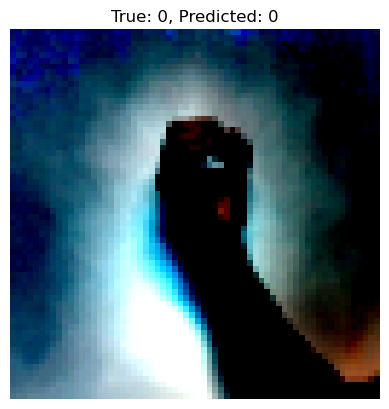

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7195915938188535..1.9575876601140254].


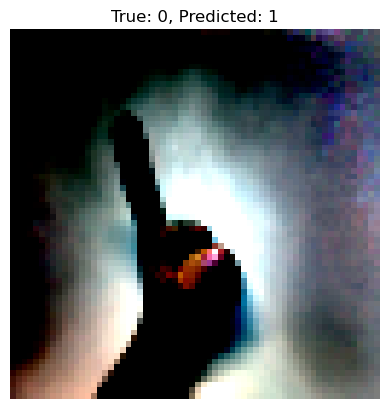

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.837978719595142..1.8176698126864834].


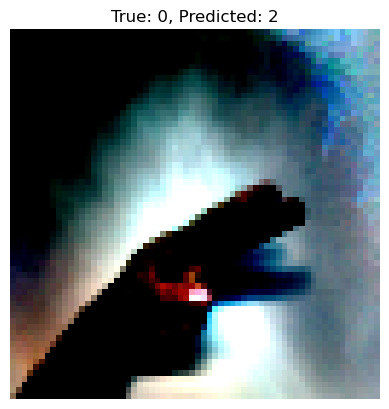

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.214027509837526..1.7576917130893979].


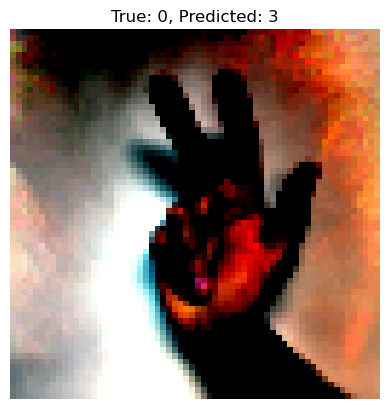

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.027646134839783..2.4657195194317523].


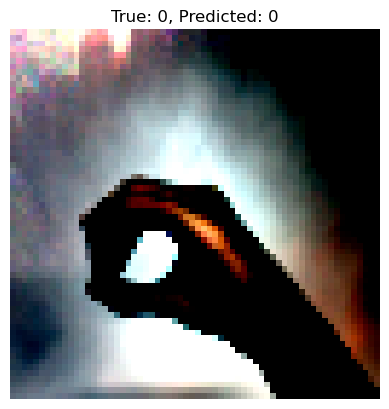

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.705724400095357..2.5952779493446294].


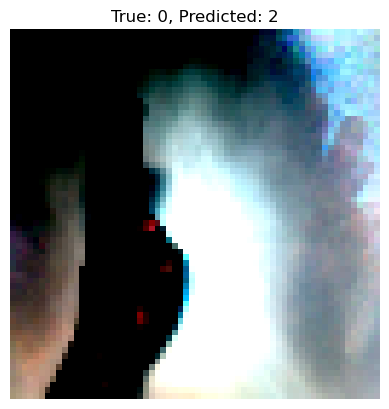

In [43]:
# visualize to evaluate the predictions
for i in range(20): 
    idx = np.random.randint(len(X_test_norm))
    image = X_test_norm[idx]
    true_label = np.argmax(y_test.iloc[idx].values)
    pred_label = np.argmax(M1.predict(np.expand_dims(image, axis=0)))

    plt.imshow(image)
    plt.title(f"True: {true_label}, Predicted: {pred_label}")
    plt.axis('off')
    plt.show()
